<a href="https://colab.research.google.com/github/Iksora03/Deep-Learning/blob/master/Inception_V1_tomato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd "/content/drive/My Drive/Tomato_Leaf/lambace"
!ls "/content/drive/My Drive/Tomato_Leaf/lambace"

/content/drive/My Drive/Tomato_Leaf/lambace
Tomato___Bacterial_spot  Tomato___Leaf_Mold
Tomato___Early_blight	 Tomato___Septoria_leaf_spot
Tomato___Late_blight	 Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [0]:
import numpy as np
import pickle
import cv2
import keras

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.layers import BatchNormalization

from os import listdir
from keras import backend as K
from keras.layers import Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [0]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((299, 299))
image_size = 0
directory_root = "/content/drive/My Drive/Tomato_Leaf/"
width=299
height=299
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [0]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    %time print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Image loading completed
CPU times: user 192 µs, sys: 0 ns, total: 192 µs
Wall time: 166 µs


In [0]:
image_size = len(image_list)

In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [0]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
base_model = InceptionV3(weights=None, include_top=False, input_tensor=Input(shape = (width, height, depth)))

x = base_model.output
output = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
___________

In [0]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [0]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/50
30/30 [==============================] - 24s 815ms/step - loss: 0.5565 - accuracy: 0.8307 - val_loss: 4.1011 - val_accuracy: 0.7333
Epoch 2/50
30/30 [==============================] - 18s 616ms/step - loss: 0.4169 - accuracy: 0.8575 - val_loss: 4.3788 - val_accuracy: 0.7153
Epoch 3/50
30/30 [==============================] - 19s 645ms/step - loss: 0.4116 - accuracy: 0.8528 - val_loss: 4.3788 - val_accuracy: 0.7153
Epoch 4/50
30/30 [==============================] - 19s 641ms/step - loss: 0.3703 - accuracy: 0.8604 - val_loss: 4.3788 - val_accuracy: 0.7153
Epoch 5/50
30/30 [==============================] - 19s 641ms/step - loss: 0.3250 - accuracy: 0.8743 - val_loss: 2.2134 - val_accuracy: 0.7083
Epoch 6/50
30/30 [==============================] - 19s 642ms/step - loss: 0.4366 - accuracy: 0.8498 - val_loss: 1.2268 - val_accuracy: 0.7153
Epoch 7/50
30/30 [==============================] - 19s 641ms/step - loss: 0.5001 - accuracy: 0.8359 - val_loss: 4.3788 - val_accuracy: 0.7153

In [0]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

240/240 [==============================] - 1s 5ms/step
Test Accuracy: 91.8749988079071


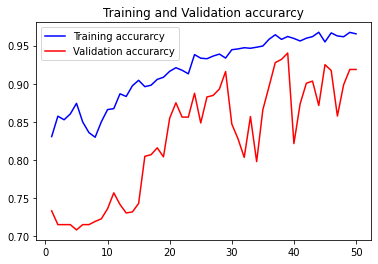

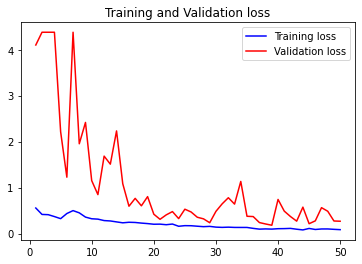

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [0]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=25, verbose=1
    )

Epoch 1/25
30/30 [==============================] - 21s 694ms/step - loss: 0.0922 - accuracy: 0.9651 - val_loss: 0.2101 - val_accuracy: 0.9257
Epoch 2/25
30/30 [==============================] - 19s 649ms/step - loss: 0.0915 - accuracy: 0.9667 - val_loss: 0.4899 - val_accuracy: 0.8931
Epoch 3/25
30/30 [==============================] - 19s 648ms/step - loss: 0.0881 - accuracy: 0.9686 - val_loss: 0.3122 - val_accuracy: 0.9062
Epoch 4/25
30/30 [==============================] - 19s 639ms/step - loss: 0.0825 - accuracy: 0.9712 - val_loss: 0.7035 - val_accuracy: 0.8507
Epoch 5/25
30/30 [==============================] - 19s 648ms/step - loss: 0.0695 - accuracy: 0.9755 - val_loss: 0.2536 - val_accuracy: 0.9111
Epoch 6/25
30/30 [==============================] - 19s 641ms/step - loss: 0.0867 - accuracy: 0.9681 - val_loss: 0.5232 - val_accuracy: 0.8729
Epoch 7/25
23/30 [======================>.......] - ETA: 4s - loss: 0.0855 - accuracy: 0.9678

WARNING:tensorflow:From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
50/50 [==============================] - 27s 544ms/step - loss: 0.2929 - acc: 0.9066 - val_loss: 0.2728 - val_acc: 0.9227
Epoch 2/25
50/50 [==============================] - 22s 442ms/step - loss: 0.2140 - acc: 0.9279 - val_loss: 0.7363 - val_acc: 0.8725
Epoch 3/25
50/50 [==============================] - 23s 454ms/step - loss: 0.1878 - acc: 0.9356 - val_loss: 1.4424 - val_acc: 0.8540
Epoch 4/25
50/50 [==============================] - 22s 435ms/step - loss: 0.1641 - acc: 0.9417 - val_loss: 0.7191 - val_acc: 0.8930
Epoch 5/25
50/50 [==============================] - 22s 441ms/step - loss: 0.1373 - acc: 0.9512 - val_loss: 1.5633 - val_acc: 0.8478
Epoch 6/25
50/50 [==============================] - 22s 443ms/step - loss: 0.1237 - acc: 0.9558 - val_loss: 0.3107 - val_acc: 0.9228
Epoch 7/25
50/50 [==============================] - 22s 436ms/step - loss: 0.1210 - acc: 0.9557 - val_loss: 0.2629 - val_acc: 0.9352
Epoch 8/25
50/50 [==============================] - 22s 435ms/step - loss: 0.1250 - acc: 0.9552 - val_loss: 1.3497 - val_acc: 0.8540
Epoch 9/25
50/50 [==============================] - 21s 429ms/step - loss: 0.1207 - acc: 0.9566 - val_loss: 0.7449 - val_acc: 0.8795
Epoch 10/25
50/50 [==============================] - 22s 434ms/step - loss: 0.0929 - acc: 0.9652 - val_loss: 0.4228 - val_acc: 0.9270
Epoch 11/25
50/50 [==============================] - 22s 440ms/step - loss: 0.1088 - acc: 0.9591 - val_loss: 0.6005 - val_acc: 0.9010
Epoch 12/25
50/50 [==============================] - 22s 442ms/step - loss: 0.1025 - acc: 0.9621 - val_loss: 0.5975 - val_acc: 0.8980
Epoch 13/25
50/50 [==============================] - 21s 428ms/step - loss: 0.0971 - acc: 0.9641 - val_loss: 0.3312 - val_acc: 0.9290
Epoch 14/25
50/50 [==============================] - 21s 426ms/step - loss: 0.0795 - acc: 0.9707 - val_loss: 0.8474 - val_acc: 0.8925
Epoch 15/25
50/50 [==============================] - 21s 417ms/step - loss: 0.0674 - acc: 0.9746 - val_loss: 0.8042 - val_acc: 0.8930
Epoch 16/25
50/50 [==============================] - 21s 423ms/step - loss: 0.0662 - acc: 0.9755 - val_loss: 0.3926 - val_acc: 0.9213
Epoch 17/25
50/50 [==============================] - 23s 453ms/step - loss: 0.0614 - acc: 0.9761 - val_loss: 0.2287 - val_acc: 0.9365
Epoch 18/25
50/50 [==============================] - 22s 432ms/step - loss: 0.0732 - acc: 0.9719 - val_loss: 0.3099 - val_acc: 0.9245
Epoch 19/25
50/50 [==============================] - 22s 431ms/step - loss: 0.0667 - acc: 0.9750 - val_loss: 0.7304 - val_acc: 0.8967
Epoch 20/25
50/50 [==============================] - 21s 430ms/step - loss: 0.0635 - acc: 0.9756 - val_loss: 0.1854 - val_acc: 0.9515
Epoch 21/25
50/50 [==============================] - 21s 412ms/step - loss: 0.0911 - acc: 0.9674 - val_loss: 0.4435 - val_acc: 0.9065
Epoch 22/25
50/50 [==============================] - 21s 417ms/step - loss: 0.0708 - acc: 0.9728 - val_loss: 1.4432 - val_acc: 0.8408
Epoch 23/25
50/50 [==============================] - 21s 413ms/step - loss: 0.0669 - acc: 0.9755 - val_loss: 0.3724 - val_acc: 0.9277
Epoch 24/25
50/50 [==============================] - 21s 424ms/step - loss: 0.0641 - acc: 0.9760 - val_loss: 0.2344 - val_acc: 0.9505
Epoch 25/25
50/50 [==============================] - 21s 423ms/step - loss: 0.0532 - acc: 0.9804 - val_loss: 0.4998 - val_acc: 0.9187

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

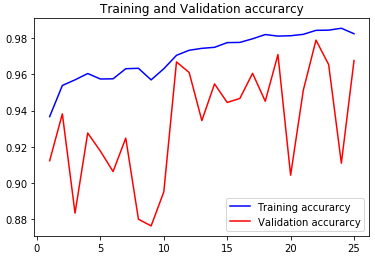

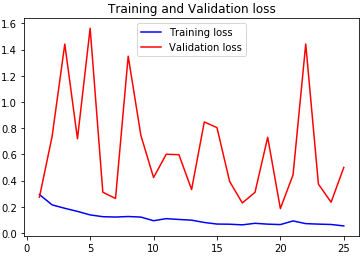